In [3]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage import io
import os
import cv2
from tqdm import tqdm
import albumentations as A
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics
import random
from albumentations.pytorch.transforms import ToTensorV2



HELLO


In [70]:
# read dataframe

os.chdir(r'C:\WORKS\Master_Thesis\DeepGlobeDataset\archive')

train = pd.read_csv(os.path.join(os.getcwd(), 'metadata.csv'))
test = train[train['split'] == 'test']
val = train[train['split'] == 'val']
train = train[train['split'] == 'train']


# size of file
train.shape

(6226, 4)

#### Utils

In [71]:
class CFG:
    seed = 42


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True, warn_only=True)
seed_everything(CFG.seed)



# plots mask image
def show_mask(masks, figsize=(10, 10)):
    f, axarr = plt.subplots(figsize=figsize)
    axarr.imshow(masks, cmap='gray')


def show_rgb_image(rgb_image, figsize=(10, 10)):
    f, axarr = plt.subplots(figsize=figsize)
    axarr.imshow(rgb_image)


def plot_images(**image_cmap_pairs):
    """PLot images in one row
    """
    n = len(image_cmap_pairs)
    plt.figure(figsize=(16, 5))
    for i, (name, image_cmap) in enumerate(image_cmap_pairs.items()):
        image, cmap = image_cmap
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')))
        plt.imshow(image, cmap=cmap)
    plt.tight_layout()
    plt.show()

#### Custom Dataset Class

In [ ]:
class DeepGlobeDataset(torch.utils.data.Dataset):
    CLASSES = ['road_boundary', 'road_footprint']
    
    def __init__(
                self,
                data_list,
                image_dir,
                mask_dir,
                classes=None,
                augmentation=None
                ):
        
       
        
        # generate full path to image/mask file
        self.image_paths, self.mask_paths = [], []
        for data in data_list:
            self.image_paths.append(os.path.join(image_dir, data))
            mask_name = data.split('/')[-1].split('.')[0].split('_')[0] + '_mask.png'
            self.mask_paths.append(os.path.join(mask_dir, mask_name))
         
        # convert str names to class values on masks
        if not classes:
            classes = self.CLASSES
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        print(self.class_values)
        
        # initialise augmentation if it exists
        self.augmentation = augmentation
    
    def __getitem__(self, i):
        image = io.imread(self.image_paths[i])
        mask = io.imread(self.mask_paths[i])

        # # extract certain classes from mask
        mask = mask[:, :, 0]
        # normalise mask
        mask = mask/255
                             
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # print(mask.shape)
       
        # for the returned mask, 0 is boundary 1 is the footprint(full mask)  
        return image, mask
    
    def __len__(self):
        return len(self.image_paths)
    
    def mask_channel_of(self, class_name):
        assert class_name in self.CLASSES
        return self.class_values.index(self.CLASSES.index(class_name))

    


#### Augmentations

In [112]:
def get_training_augmentation():
    train_transform = A.Compose([
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.5),
        A.Resize(512, 512),
        A.Normalize(normalization='min_max_per_channel'),
        ToTensorV2(),
    ])
    return train_transform


def get_validation_augmentation():
    test_transform = A.Compose([
        A.Normalize(normalization='min_max_per_channel'),
        ToTensorV2(),
    ])
    return test_transform


[0, 1]


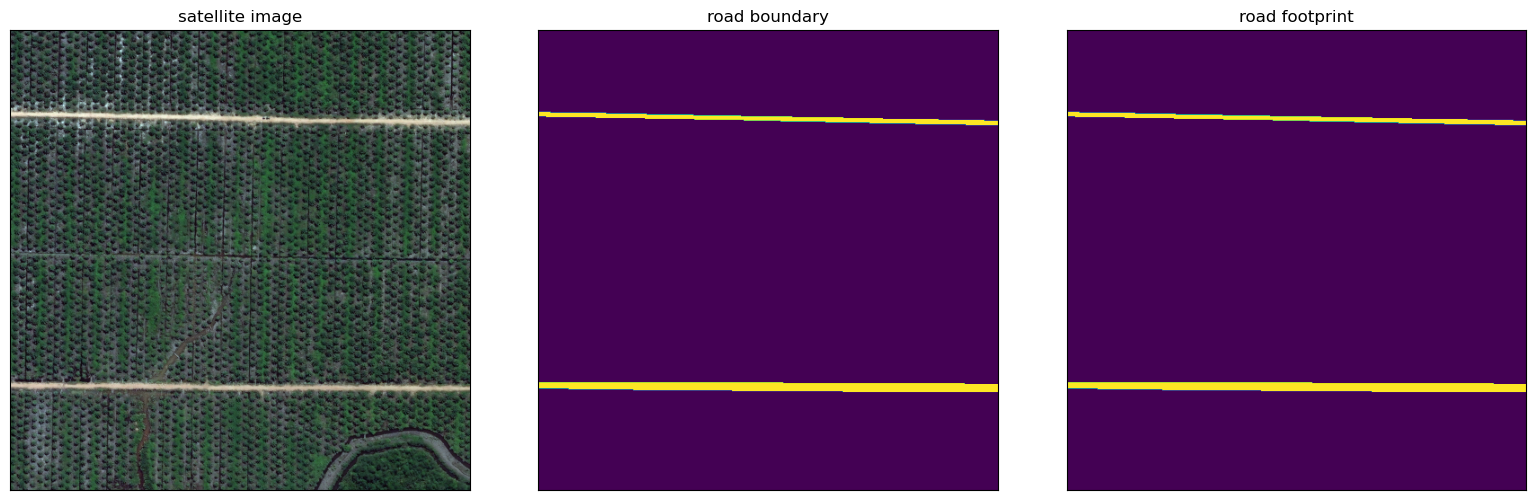

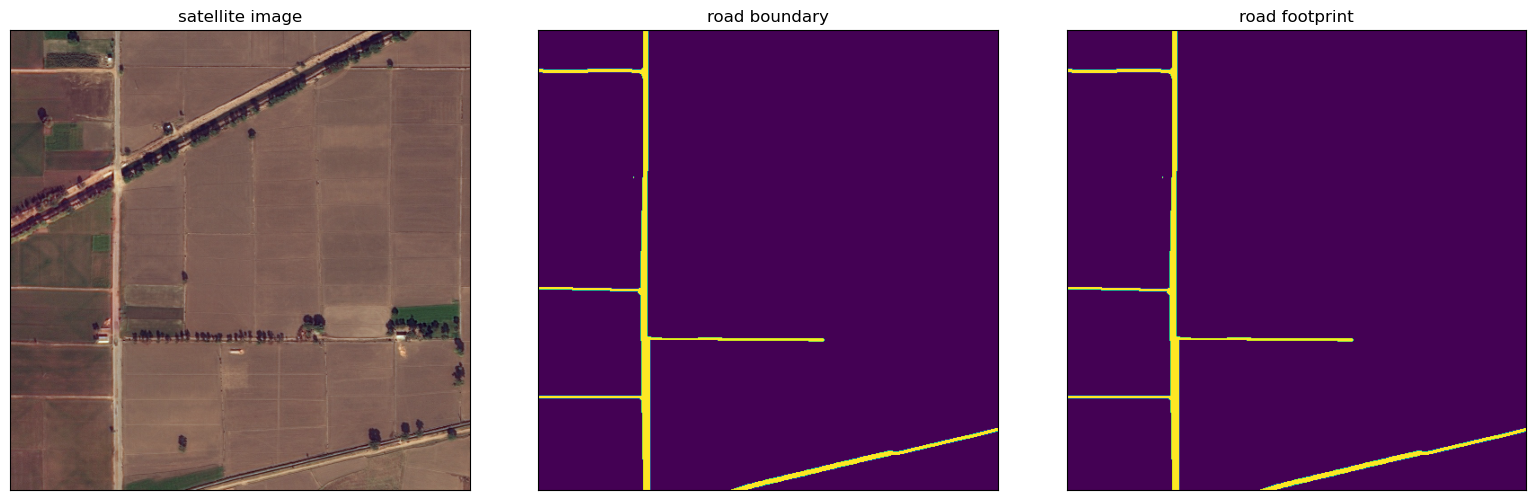

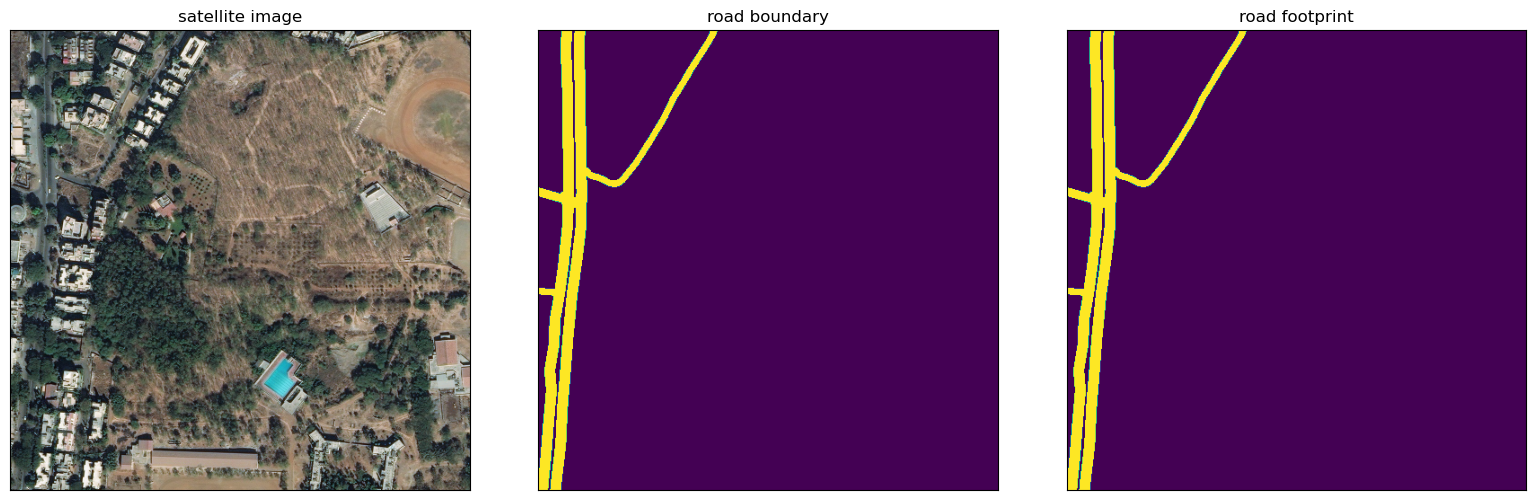

In [74]:
#### Visualize resulted augmented images and masks

train_list = train['sat_image_path'].tolist()[0:11]
image_dir = r'C:\WORKS\Master_Thesis\DeepGlobeDataset\archive'
mask_dir = r'C:\WORKS\Master_Thesis\DeepGlobeDataset\archive\train'

# Custom dataset
demo_dataset = DeepGlobeDataset(train_list, image_dir, mask_dir, augmentation=get_training_augmentation())


channel_footprint = demo_dataset.mask_channel_of('road_footprint')
channel_boundary = demo_dataset.mask_channel_of('road_boundary')

for i in [1, 5, 9]:
    image, mask = demo_dataset.__getitem__(i)

    image = image.permute(1, 2, 0)


    plot_images(
        satellite_image=(image[:, :, :], 'gray'),
        road_boundary=(mask[:, :, channel_boundary], 'viridis'),
        road_footprint=(mask[:, :, channel_footprint], 'viridis')
    )

#### Modelling

In [75]:
# ---------------------------------------------------------------
# Copyright (c) 2021, NVIDIA Corporation. All rights reserved.
#
# This work is licensed under the NVIDIA Source Code License
# ---------------------------------------------------------------
import math
import warnings
import numpy as np
from functools import partial

import torch
import torch.nn as nn


def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    r"""
    Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.
    Args:
        tensor: an n-dimensional `torch.Tensor`
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.trunc_normal_(w)
    """
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)

#--------------------------------------#
#   Gelu激活函数的实现
#   利用近似的数学公式
#--------------------------------------#
class GELU(nn.Module):
    def __init__(self):
        super(GELU, self).__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * torch.pow(x,3))))

class OverlapPatchEmbed(nn.Module):
    def __init__(self, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        patch_size  = (patch_size, patch_size)
        self.proj   = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm   = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W

#--------------------------------------------------------------------------------------------------------------------#
#   Attention机制
#   将输入的特征qkv特征进行划分，首先生成query, key, value。query是查询向量、key是键向量、v是值向量。
#   然后利用 查询向量query 叉乘 转置后的键向量key，这一步可以通俗的理解为，利用查询向量去查询序列的特征，获得序列每个部分的重要程度score。
#   然后利用 score 叉乘 value，这一步可以通俗的理解为，将序列每个部分的重要程度重新施加到序列的值上去。
#   
#   在segformer中，为了减少计算量，首先对特征图进行了浓缩，所有特征层都压缩到原图的1/32。
#   当输入图片为512, 512时，Block1的特征图为128, 128，此时就先将特征层压缩为16, 16。
#   在Block1的Attention模块中，相当于将8x8个特征点进行特征浓缩，浓缩为一个特征点。
#   然后利用128x128个查询向量对16x16个键向量与值向量进行查询。尽管键向量与值向量的数量较少，但因为查询向量的不同，依然可以获得不同的输出。
#--------------------------------------------------------------------------------------------------------------------#
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim        = dim
        self.num_heads  = num_heads
        head_dim        = dim // num_heads
        self.scale      = qk_scale or head_dim ** -0.5

        self.q          = nn.Linear(dim, dim, bias=qkv_bias)
        
        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr     = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm   = nn.LayerNorm(dim)
        self.kv         = nn.Linear(dim, dim * 2, bias=qkv_bias)
        
        self.attn_drop  = nn.Dropout(attn_drop)
        
        self.proj       = nn.Linear(dim, dim)
        self.proj_drop  = nn.Dropout(proj_drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        B, N, C = x.shape
        # bs, 16384, 32 => bs, 16384, 32 => bs, 16384, 8, 4 => bs, 8, 16384, 4
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        if self.sr_ratio > 1:
            # bs, 16384, 32 => bs, 32, 128, 128
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            # bs, 32, 128, 128 => bs, 32, 16, 16 => bs, 256, 32
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.norm(x_)
            # bs, 256, 32 => bs, 256, 64 => bs, 256, 2, 8, 4 => 2, bs, 8, 256, 4
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]

        # bs, 8, 16384, 4 @ bs, 8, 4, 256 => bs, 8, 16384, 256 
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # bs, 8, 16384, 256  @ bs, 8, 256, 4 => bs, 8, 16384, 4 => bs, 16384, 32
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        # bs, 16384, 32 => bs, 16384, 32
        x = self.proj(x)
        x = self.proj_drop(x)

        return x

def drop_path(x, drop_prob: float = 0., training: bool = False, scale_by_keep: bool = True):
    """
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob       = 1 - drop_prob
    shape           = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor   = x.new_empty(shape).bernoulli_(keep_prob)
    if keep_prob > 0.0 and scale_by_keep:
        random_tensor.div_(keep_prob)
    return x * random_tensor

class DropPath(nn.Module):
    def __init__(self, drop_prob=None, scale_by_keep=True):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training, self.scale_by_keep)
    
class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x
    
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=GELU, drop=0.):
        super().__init__()
        out_features    = out_features or in_features
        hidden_features = hidden_features or in_features
        
        self.fc1    = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act    = act_layer()
        
        self.fc2    = nn.Linear(hidden_features, out_features)
        
        self.drop   = nn.Dropout(drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = self.fc1(x)
        x = self.dwconv(x, H, W)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()
        self.norm1      = norm_layer(dim)
        
        self.attn       = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio
        )
        self.norm2      = norm_layer(dim)
        self.mlp        = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer, drop=drop)

        self.drop_path  = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))
        return x

class MixVisionTransformer(nn.Module):
    def __init__(self, in_chans=3, num_classes=1000, embed_dims=[32, 64, 160, 256],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1]):
        super().__init__()
        self.num_classes    = num_classes
        self.depths         = depths

        #----------------------------------#
        #   Transformer模块，共有四个部分
        #----------------------------------#
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        
        #----------------------------------#
        #   block1
        #----------------------------------#
        #-----------------------------------------------#
        #   对输入图像进行分区，并下采样
        #   512, 512, 3 => 128, 128, 32 => 16384, 32
        #-----------------------------------------------#
        self.patch_embed1 = OverlapPatchEmbed(patch_size=7, stride=4, in_chans=in_chans, embed_dim=embed_dims[0])
        #-----------------------------------------------#
        #   利用transformer模块进行特征提取
        #   16384, 32 => 16384, 32
        #-----------------------------------------------#
        cur = 0
        self.block1 = nn.ModuleList(
            [
                Block(
                    dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=mlp_ratios[0], qkv_bias=qkv_bias, qk_scale=qk_scale,
                    drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer, sr_ratio=sr_ratios[0]
                )
                for i in range(depths[0])
            ]
        )
        self.norm1 = norm_layer(embed_dims[0])
        
        #----------------------------------#
        #   block2
        #----------------------------------#
        #-----------------------------------------------#
        #   对输入图像进行分区，并下采样
        #   128, 128, 32 => 64, 64, 64 => 4096, 64
        #-----------------------------------------------#
        self.patch_embed2 = OverlapPatchEmbed(patch_size=3, stride=2, in_chans=embed_dims[0], embed_dim=embed_dims[1])
        #-----------------------------------------------#
        #   利用transformer模块进行特征提取
        #   4096, 64 => 4096, 64
        #-----------------------------------------------#
        cur += depths[0]
        self.block2 = nn.ModuleList(
            [
                Block(
                    dim=embed_dims[1], num_heads=num_heads[1], mlp_ratio=mlp_ratios[1], qkv_bias=qkv_bias, qk_scale=qk_scale,
                    drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer, sr_ratio=sr_ratios[1]
                )
                for i in range(depths[1])
            ]
        )
        self.norm2 = norm_layer(embed_dims[1])

        #----------------------------------#
        #   block3
        #----------------------------------#
        #-----------------------------------------------#
        #   对输入图像进行分区，并下采样
        #   64, 64, 64 => 32, 32, 160 => 1024, 160
        #-----------------------------------------------#
        self.patch_embed3 = OverlapPatchEmbed(patch_size=3, stride=2, in_chans=embed_dims[1], embed_dim=embed_dims[2])
        #-----------------------------------------------#
        #   利用transformer模块进行特征提取
        #   1024, 160 => 1024, 160
        #-----------------------------------------------#
        cur += depths[1]
        self.block3 = nn.ModuleList(
            [
                Block(
                    dim=embed_dims[2], num_heads=num_heads[2], mlp_ratio=mlp_ratios[2], qkv_bias=qkv_bias, qk_scale=qk_scale,
                    drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer, sr_ratio=sr_ratios[2]
                )
                for i in range(depths[2])
            ]
        )
        self.norm3 = norm_layer(embed_dims[2])

        #----------------------------------#
        #   block4
        #----------------------------------#
        #-----------------------------------------------#
        #   对输入图像进行分区，并下采样
        #   32, 32, 160 => 16, 16, 256 => 256, 256
        #-----------------------------------------------#
        self.patch_embed4 = OverlapPatchEmbed(patch_size=3, stride=2, in_chans=embed_dims[2], embed_dim=embed_dims[3])
        #-----------------------------------------------#
        #   利用transformer模块进行特征提取
        #   256, 256 => 256, 256
        #-----------------------------------------------#
        cur += depths[2]
        self.block4 = nn.ModuleList(
            [
                Block(
                    dim=embed_dims[3], num_heads=num_heads[3], mlp_ratio=mlp_ratios[3], qkv_bias=qkv_bias, qk_scale=qk_scale,
                    drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer, sr_ratio=sr_ratios[3]
                )
                for i in range(depths[3])
            ]
        )
        self.norm4 = norm_layer(embed_dims[3])

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()
                
    def forward(self, x):
        B = x.shape[0]
        outs = []

        #----------------------------------#
        #   block1
        #----------------------------------#
        x, H, W = self.patch_embed1.forward(x)
        for i, blk in enumerate(self.block1):
            x = blk.forward(x, H, W)
        x = self.norm1(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        #----------------------------------#
        #   block2
        #----------------------------------#
        x, H, W = self.patch_embed2.forward(x)
        for i, blk in enumerate(self.block2):
            x = blk.forward(x, H, W)
        x = self.norm2(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        #----------------------------------#
        #   block3
        #----------------------------------#
        x, H, W = self.patch_embed3.forward(x)
        for i, blk in enumerate(self.block3):
            x = blk.forward(x, H, W)
        x = self.norm3(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        #----------------------------------#
        #   block4
        #----------------------------------#
        x, H, W = self.patch_embed4.forward(x)
        for i, blk in enumerate(self.block4):
            x = blk.forward(x, H, W)
        x = self.norm4(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        return outs

class mit_b0(MixVisionTransformer):
    def __init__(self, pretrained = False):
        super(mit_b0, self).__init__(
            embed_dims=[32, 64, 160, 256], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)
        if pretrained:
            print("Load backbone weights")
            self.load_state_dict(torch.load(r"C:\WORKS\Master_Thesis\Codes\DeepGlobe\segformer_b0_backbone_weights.pth"), strict=False)

class mit_b1(MixVisionTransformer):
    def __init__(self, pretrained = False):
        super(mit_b1, self).__init__(
            embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)
        if pretrained:
            print("Load backbone weights")
            self.load_state_dict(torch.load("model_data/segformer_b1_backbone_weights.pth"), strict=False)

class mit_b2(MixVisionTransformer):
    def __init__(self, pretrained = False):
        super(mit_b2, self).__init__(
            embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)
        if pretrained:
            print("Load backbone weights")
            self.load_state_dict(torch.load("model_data/segformer_b2_backbone_weights.pth"), strict=False)

class mit_b3(MixVisionTransformer):
    def __init__(self, pretrained = False):
        super(mit_b3, self).__init__(
            embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 18, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)
        if pretrained:
            print("Load backbone weights")
            self.load_state_dict(torch.load("model_data/segformer_b3_backbone_weights.pth"), strict=False)

class mit_b4(MixVisionTransformer):
    def __init__(self, pretrained = False):
        super(mit_b4, self).__init__(
            embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 8, 27, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)
        if pretrained:
            print("Load backbone weights")
            self.load_state_dict(torch.load("model_data/segformer_b4_backbone_weights.pth"), strict=False)

class mit_b5(MixVisionTransformer):
    def __init__(self, pretrained = False):
        super(mit_b5, self).__init__(
            embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 6, 40, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)
        if pretrained:
            print("Load backbone weights")
            self.load_state_dict(torch.load("model_data/segformer_b5_backbone_weights.pth"), strict=False)

In [76]:
# ---------------------------------------------------------------
# Copyright (c) 2021, NVIDIA Corporation. All rights reserved.
#
# This work is licensed under the NVIDIA Source Code License
# ---------------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F



class SELayer(nn.Module):
    def __init__(self, channel, reduction=3):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class Connect(nn.Module):
    def __init__(self, num_classes, num_neighbor, embedding_dim=768,reduction=3,dropout_ratio=0.1):
        super(Connect, self).__init__()

        self.seg_branch = nn.Sequential(nn.Conv2d(embedding_dim, 64, 3, stride=1, padding=1),
                                        nn.ReLU(),
                                        nn.Dropout2d(dropout_ratio),
                                        nn.Conv2d(64, num_classes, kernel_size=1, stride=1))

        self.connect_branch = nn.Sequential(nn.Conv2d(embedding_dim, 64, 3, stride=1, padding=1),
                                        nn.ReLU(),
                                        nn.Conv2d(64, num_neighbor, 3, padding=1, dilation=1),
                                            )
        self.se = SELayer(num_neighbor, reduction)

        self.connect_branch_d1 = nn.Sequential(nn.Conv2d(embedding_dim, 64, 3, stride=1, padding=1),
                                            nn.ReLU(),
                                            nn.Conv2d(64, num_neighbor, 3, padding=3, dilation=3),
                                               )
        self.se_d1 = SELayer(num_neighbor, reduction)

        # self.linear_pred = nn.Conv2d(embedding_dim, num_classes, kernel_size=1)
        # self.dropout = nn.Dropout2d(dropout_ratio)

        self._init_weight()


    def forward(self, input):
        seg = self.seg_branch(input)

        con = self.connect_branch(input)
        con0 = self.se(con)

        con_d1 = self.connect_branch_d1(input)
        con1 = self.se_d1(con_d1)

        return seg, con0, con1

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.ConvTranspose2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


class MLP(nn.Module):
    """
    Linear Embedding
    """
    def __init__(self, input_dim=2048, embed_dim=768):
        super().__init__()
        self.proj = nn.Linear(input_dim, embed_dim)

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        return x
    
class ConvModule(nn.Module):
    def __init__(self, c1, c2, k=1, s=1, p=0, g=1, act=True):
        super(ConvModule, self).__init__()
        self.conv   = nn.Conv2d(c1, c2, k, s, p, groups=g, bias=False)
        self.bn     = nn.BatchNorm2d(c2, eps=0.001, momentum=0.03)
        self.act    = nn.ReLU() if act is True else (act if isinstance(act, nn.Module) else nn.Identity())

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def fuseforward(self, x):
        return self.act(self.conv(x))

class SegFormerHead(nn.Module):
    """
    SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers
    """
    def __init__(self, num_classes=20, in_channels=[32, 64, 160, 256], embedding_dim=768, dropout_ratio=0.1):
        super(SegFormerHead, self).__init__()
        c1_in_channels, c2_in_channels, c3_in_channels, c4_in_channels = in_channels

        self.linear_c4 = MLP(input_dim=c4_in_channels, embed_dim=embedding_dim)
        self.linear_c3 = MLP(input_dim=c3_in_channels, embed_dim=embedding_dim)
        self.linear_c2 = MLP(input_dim=c2_in_channels, embed_dim=embedding_dim)
        self.linear_c1 = MLP(input_dim=c1_in_channels, embed_dim=embedding_dim)

        self.linear_fuse = ConvModule(
            c1=embedding_dim*4,
            c2=embedding_dim,
            k=1,
        )
        self.con = Connect(num_classes,9,embedding_dim)
        # self.linear_pred    = nn.Conv2d(embedding_dim, num_classes, kernel_size=1)
        # self.dropout        = nn.Dropout2d(dropout_ratio)
    
    def forward(self, inputs):
        c1, c2, c3, c4 = inputs

        ############## MLP decoder on C1-C4 ###########
        n, _, h, w = c4.shape
        
        _c4 = self.linear_c4(c4).permute(0,2,1).reshape(n, -1, c4.shape[2], c4.shape[3])
        _c4 = F.interpolate(_c4, size=c1.size()[2:], mode='bilinear', align_corners=False)

        _c3 = self.linear_c3(c3).permute(0,2,1).reshape(n, -1, c3.shape[2], c3.shape[3])
        _c3 = F.interpolate(_c3, size=c1.size()[2:], mode='bilinear', align_corners=False)

        _c2 = self.linear_c2(c2).permute(0,2,1).reshape(n, -1, c2.shape[2], c2.shape[3])
        _c2 = F.interpolate(_c2, size=c1.size()[2:], mode='bilinear', align_corners=False)

        _c1 = self.linear_c1(c1).permute(0,2,1).reshape(n, -1, c1.shape[2], c1.shape[3])

        _c = self.linear_fuse(torch.cat([_c4, _c3, _c2, _c1], dim=1))


        seg, con0, con1 = self.con(_c)


        # x = self.dropout(_c)
        # x = self.linear_pred(x)

        return seg, con0, con1

class SegFormer(nn.Module):
    def __init__(self, num_classes = 21, phi = 'b0', pretrained = False):
        super(SegFormer, self).__init__()
        self.in_channels = {
            'b0': [32, 64, 160, 256]
        }[phi]
        self.backbone   = {
            'b0': mit_b0
        }[phi](pretrained)
        self.embedding_dim   = {
            'b0': 256
        }[phi]
        self.decode_head = SegFormerHead(num_classes, self.in_channels, self.embedding_dim)

    def forward(self, inputs):
        H, W = inputs.size(2), inputs.size(3)
        
        x = self.backbone.forward(inputs)
        seg, con0, con1 = self.decode_head.forward(x)
        
        seg = F.interpolate(seg, size=(H, W), mode='bilinear', align_corners=True)
        con0 = F.interpolate(con0, size=(H, W), mode='bilinear', align_corners=True)
        con1 = F.interpolate(con1, size=(H, W), mode='bilinear', align_corners=True)

        return seg, con0, con1


if __name__ == '__main__':
    model = SegFormer(2)
    input = torch.randn(1,3,512,512)
    out = model(input)
    for i in out:
        print(i.shape)

torch.Size([1, 2, 512, 512])
torch.Size([1, 9, 512, 512])
torch.Size([1, 9, 512, 512])


In [26]:
def preprocess_input(image):
    image -= np.array([123.675, 116.28, 103.53], np.float32)
    image /= np.array([58.395, 57.12, 57.375], np.float32)
    return image

In [25]:
def cvtColor(image):
    if len(np.shape(image)) == 3 and np.shape(image)[2] == 3:
        return image 
    else:
        image = image.convert('RGB')
        return image 

In [145]:
mask = io.imread(os.path.join(image_dir, '1849_mask.png'))
mask = mask[:, :, 0]
mask = np.array(mask/255, dtype=np.int16)

In [146]:
seg_label = np.eye(2)[mask.reshape([-1])]

seg_reshaped = seg_label.reshape((mask.shape[0], mask.shape[1], 2))

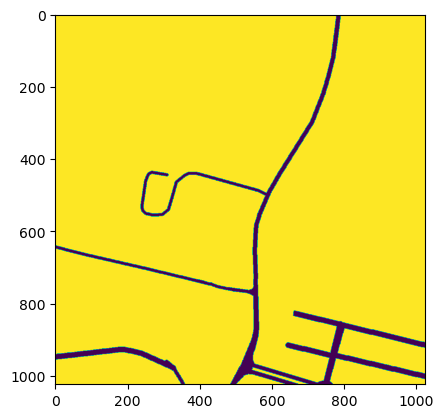

In [147]:
plt.imshow(seg_reshaped[:, :, 0])

In [141]:
np.array_equal(seg_reshaped[:, :, 0], seg_reshaped[:, :, 1])

False

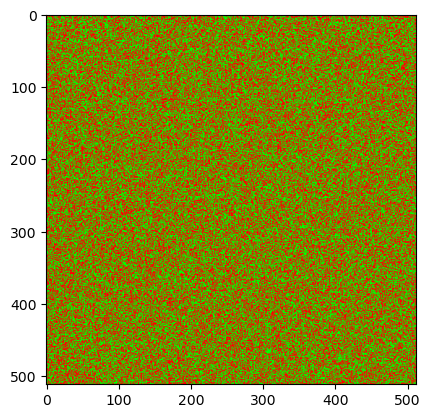

In [78]:
plt.imshow(seg_reshaped)

In [27]:
# dataloader

import os

import cv2
import numpy as np
import torch
from PIL import Image
from torch.utils.data.dataset import Dataset
from numba import jit

class SegmentationDataset(Dataset):
    def __init__(self, annotation_lines, input_shape, num_classes, train, dataset_path):
        super(SegmentationDataset, self).__init__()
        self.annotation_lines   = annotation_lines
        self.length             = len(annotation_lines)
        self.input_shape        = input_shape
        self.num_classes        = num_classes
        self.train              = train
        self.dataset_path       = dataset_path

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        annotation_line = self.annotation_lines[index]
        name            = annotation_line.split()[0]

        #-------------------------------#
        #   从文件中读取图像
        #-------------------------------#
        jpg         = Image.open(os.path.join(os.path.join(self.dataset_path, "VOC2007/JPEGImages"), name + ".jpg"))
        png         = Image.open(os.path.join(os.path.join(self.dataset_path, "VOC2007/SegmentationClass"), name + ".png"))
        #-------------------------------#
        #   数据增强
        #-------------------------------#
        jpg, png    = self.get_random_data(jpg, png, self.input_shape, random = self.train)

        jpg         = np.transpose(preprocess_input(np.array(jpg, np.float64)), [2,0,1])
        png         = np.array(png)
        png[png >= self.num_classes] = self.num_classes
        #-------------------------------------------------------#
        #   转化成one_hot的形式
        #   在这里需要+1是因为voc数据集有些标签具有白边部分
        #   我们需要将白边部分进行忽略，+1的目的是方便忽略。
        #-------------------------------------------------------#
        seg_labels  = np.eye(self.num_classes + 1)[png.reshape([-1])]
        seg_labels  = seg_labels.reshape((int(self.input_shape[0]), int(self.input_shape[1]), self.num_classes + 1))

        return jpg, png,self.get_con_1(png),self.get_con_3(png), seg_labels

    def rand(self, a=0, b=1):
        return np.random.rand() * (b - a) + a

    #@jit(nopython=True)
    def get_con_1(self,png):
        img = np.where(png > 0, 1, 0)
        shp = img.shape

        img_pad = np.zeros([shp[0] + 4, shp[0] + 4])
        img_pad[2:-2, 2:-2] = img
        dir_array0 = np.zeros([shp[0], shp[1], 9])

        for i in range(shp[0]):
            for j in range(shp[1]):
                if img[i, j] == 0:
                    continue
                dir_array0[i, j, 0] = img_pad[i, j]
                dir_array0[i, j, 1] = img_pad[i, j + 2]
                dir_array0[i, j, 2] = img_pad[i, j + 4]
                dir_array0[i, j, 3] = img_pad[i + 2, j]
                dir_array0[i, j, 4] = img_pad[i + 2, j + 2]
                dir_array0[i, j, 5] = img_pad[i + 2, j + 4]
                dir_array0[i, j, 6] = img_pad[i + 4, j]
                dir_array0[i, j, 7] = img_pad[i + 4, j + 2]
                dir_array0[i, j, 8] = img_pad[i + 4, j + 4]
        return dir_array0

    #@jit(nopython=True)
    def get_con_3(self,png):
        img = np.where(png > 0, 1, 0)
        shp = img.shape

        img_pad = np.zeros([shp[0] + 8, shp[0] + 8])
        img_pad[4:-4, 4:-4] = img
        dir_array0 = np.zeros([shp[0], shp[1], 9])

        for i in range(shp[0]):
            for j in range(shp[1]):
                if img[i, j] == 0:
                    continue
                dir_array0[i, j, 0] = img_pad[i, j]
                dir_array0[i, j, 1] = img_pad[i, j + 4]
                dir_array0[i, j, 2] = img_pad[i, j + 8]
                dir_array0[i, j, 0] = img_pad[i + 4, j]
                dir_array0[i, j, 1] = img_pad[i + 4, j + 4]
                dir_array0[i, j, 2] = img_pad[i + 4, j + 8]
                dir_array0[i, j, 0] = img_pad[i + 8, j]
                dir_array0[i, j, 1] = img_pad[i + 8, j + 4]
                dir_array0[i, j, 2] = img_pad[i + 8, j + 8]
        return dir_array0

    def get_random_data(self, image, label, input_shape, jitter=.3, hue=.1, sat=0.7, val=0.3, random=True):
        image   = cvtColor(image)
        label   = Image.fromarray(np.array(label))
        #------------------------------#
        #   获得图像的高宽与目标高宽
        #------------------------------#
        iw, ih  = image.size
        h, w    = input_shape

        if not random:
            iw, ih  = image.size
            scale   = min(w/iw, h/ih)
            nw      = int(iw*scale)
            nh      = int(ih*scale)

            image       = image.resize((nw,nh), Image.BICUBIC)
            new_image   = Image.new('RGB', [w, h], (128,128,128))
            new_image.paste(image, ((w-nw)//2, (h-nh)//2))

            label       = label.resize((nw,nh), Image.NEAREST)
            new_label   = Image.new('L', [w, h], (0))
            new_label.paste(label, ((w-nw)//2, (h-nh)//2))
            return new_image, new_label

        #------------------------------------------#
        #   对图像进行缩放并且进行长和宽的扭曲
        #------------------------------------------#
        new_ar = iw/ih * self.rand(1-jitter,1+jitter) / self.rand(1-jitter,1+jitter)
        scale = self.rand(0.5, 2)
        if new_ar < 1:
            nh = int(scale*h)
            nw = int(nh*new_ar)
        else:
            nw = int(scale*w)
            nh = int(nw/new_ar)
        image = image.resize((nw,nh), Image.BICUBIC)
        label = label.resize((nw,nh), Image.NEAREST)
        
        #------------------------------------------#
        #   翻转图像
        #------------------------------------------#
        flip = self.rand()<.5
        if flip: 
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            label = label.transpose(Image.FLIP_LEFT_RIGHT)
        
        #------------------------------------------#
        #   将图像多余的部分加上灰条
        #------------------------------------------#
        dx = int(self.rand(0, w-nw))
        dy = int(self.rand(0, h-nh))
        new_image = Image.new('RGB', (w,h), (128,128,128))
        new_label = Image.new('L', (w,h), (0))
        new_image.paste(image, (dx, dy))
        new_label.paste(label, (dx, dy))
        image = new_image
        label = new_label

        image_data      = np.array(image, np.uint8)
        #------------------------------------------#
        #   高斯模糊
        #------------------------------------------#
        blur = self.rand() < 0.25
        if blur: 
            image_data = cv2.GaussianBlur(image_data, (5, 5), 0)

        #------------------------------------------#
        #   旋转
        #------------------------------------------#
        rotate = self.rand() < 0.25
        if rotate: 
            center      = (w // 2, h // 2)
            rotation    = np.random.randint(-10, 11)
            M           = cv2.getRotationMatrix2D(center, -rotation, scale=1)
            image_data  = cv2.warpAffine(image_data, M, (w, h), flags=cv2.INTER_CUBIC, borderValue=(128,128,128))
            label       = cv2.warpAffine(np.array(label, np.uint8), M, (w, h), flags=cv2.INTER_NEAREST, borderValue=(0))

        #---------------------------------#
        #   对图像进行色域变换
        #   计算色域变换的参数
        #---------------------------------#
        r               = np.random.uniform(-1, 1, 3) * [hue, sat, val] + 1
        #---------------------------------#
        #   将图像转到HSV上
        #---------------------------------#
        hue, sat, val   = cv2.split(cv2.cvtColor(image_data, cv2.COLOR_RGB2HSV))
        dtype           = image_data.dtype
        #---------------------------------#
        #   应用变换
        #---------------------------------#
        x       = np.arange(0, 256, dtype=r.dtype)
        lut_hue = ((x * r[0]) % 180).astype(dtype)
        lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
        lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

        image_data = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val)))
        image_data = cv2.cvtColor(image_data, cv2.COLOR_HSV2RGB)
        
        return image_data, label


def seg_dataset_collate(batch):
    images      = []
    con_1 = []
    con_3 = []
    pngs        = []
    seg_labels  = []
    for img, png,c1,c3, labels in batch:
        images.append(img)
        pngs.append(png)
        con_1.append(c1)
        con_3.append(c3)
        seg_labels.append(labels)
    images      = torch.from_numpy(np.array(images)).type(torch.FloatTensor)
    pngs        = torch.from_numpy(np.array(pngs)).long()
    con_1 = torch.from_numpy(np.array(con_1))#.long()
    con_3 = torch.from_numpy(np.array(con_3))#.long()
    seg_labels  = torch.from_numpy(np.array(seg_labels)).type(torch.FloatTensor)
    return images, pngs,con_1,con_3, seg_labels

In [ ]:
train_list = train['sat_image_path'].tolist()
image_dir = r'C:\WORKS\Master_Thesis\DeepGlobeDataset\archive'
mask_dir = r'C:\WORKS\Master_Thesis\DeepGlobeDataset\archive\train'

# dataset = SegmentationDataset(data_list= train_list, image_dir=image_dir,
#                                mask_dir=mask_dir, transform=get_training_augmentation())


demo_dataset = DeepGlobeDataset(train_list, image_dir, mask_dir, augmentation=get_training_augmentation())

[0, 1]


In [182]:
import torch.optim as optim

# Initialize the model, loss function, and optimizer
model = SegFormer(num_classes=2, phi='b0', pretrained=False)  # For example, 21 classes in the dataset
model = model.cuda()  # Move model to GPU if available
criterion = torch.nn.CrossEntropyLoss()  # For segmentation tasks
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Create DataLoader
from torch.utils.data import DataLoader
train_loader = DataLoader(demo_dataset, batch_size=8, shuffle=True)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.cuda()  # Move inputs to GPU
        targets = targets.cuda()  # Move targets to GPU

        optimizer.zero_grad()  # Clear previous gradients
        
        # Forward pass
        seg, con0, con1 = model(inputs)

        # targets = targets.squeeze(-1)

        targets = targets.argmax(dim=-1)

        # print(f'target: {targets.shape}')
        
        # Calculate loss (example: only use segmentation output for loss)
        loss = criterion(seg, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")



C:\Users\Propietario\AppData\Local\Temp\ipykernel_28568\3356004488.py:184: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\Context.cpp:208.)
  attn = (q @ k.transpose(-2, -1)) * self.scale
C:\Users\Propietario\AppData\Local\Temp\ipykernel_28568\3356004488.py:189: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is 

Epoch [1/100], Loss: 0.6144462823867798
Epoch [2/100], Loss: 0.19250953942537308
Epoch [3/100], Loss: 0.0710742175579071
Epoch [4/100], Loss: 0.028256905265152454
Epoch [5/100], Loss: 0.012255677953362465
Epoch [6/100], Loss: 0.00819444190710783
Epoch [7/100], Loss: 0.00650127325206995
Epoch [8/100], Loss: 0.0057023141998797655
Epoch [9/100], Loss: 0.0042270919075235724
Epoch [10/100], Loss: 0.003202469670213759
Epoch [11/100], Loss: 0.0016466279630549252
Epoch [12/100], Loss: 0.006620648899115622
Epoch [13/100], Loss: 0.001448237570002675
Epoch [14/100], Loss: 0.0018895570538006723
Epoch [15/100], Loss: 0.0015836573438718915
Epoch [16/100], Loss: 0.0008978963305708021
Epoch [17/100], Loss: 0.0014160571445245296
Epoch [18/100], Loss: 0.0008353541197720915
Epoch [19/100], Loss: 0.0014784542727284133
Epoch [20/100], Loss: 0.0010847178346011788
Epoch [21/100], Loss: 0.0008174136164598167
Epoch [22/100], Loss: 0.0005311442509992048
Epoch [23/100], Loss: 0.0005975402018520981
Epoch [24/100]

In [154]:
 seg, con0, con1

(tensor([[[[ 1.8912,  2.3493,  2.8075,  ...,  3.0013,  2.4397,  1.8781],
           [ 2.2497,  2.6237,  2.9977,  ...,  2.9427,  2.3823,  1.8219],
           [ 2.6081,  2.8981,  3.1880,  ...,  2.8841,  2.3248,  1.7656],
           ...,
           [ 3.2023,  3.3752,  3.5481,  ...,  7.2911,  6.8288,  6.3665],
           [ 2.7301,  2.8736,  3.0172,  ...,  6.9185,  6.4731,  6.0277],
           [ 2.2579,  2.3721,  2.4863,  ...,  6.5459,  6.1174,  5.6889]],
 
          [[-2.0086, -2.2064, -2.4041,  ..., -2.6881, -2.0553, -1.4225],
           [-2.9472, -3.1611, -3.3749,  ..., -3.3628, -2.6241, -1.8854],
           [-3.8858, -4.1158, -4.3458,  ..., -4.0375, -3.1929, -2.3482],
           ...,
           [-1.5982, -1.7450, -1.8918,  ..., -7.2163, -6.5622, -5.9080],
           [-1.3518, -1.5562, -1.7607,  ..., -6.3262, -5.7135, -5.1009],
           [-1.1054, -1.3675, -1.6296,  ..., -5.4362, -4.8649, -4.2937]]],
 
 
         [[[ 1.7817,  2.4869,  3.1921,  ...,  3.0047,  2.7404,  2.4762],
          

In [155]:
seg_one = seg[0, :, :, :]

In [156]:
seg_numpy = seg_one.permute(1, 2, 0).cpu().detach().numpy()

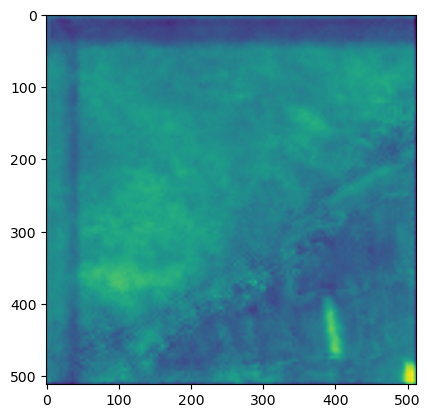

In [157]:
plt.imshow(seg_numpy[:, :, 0])

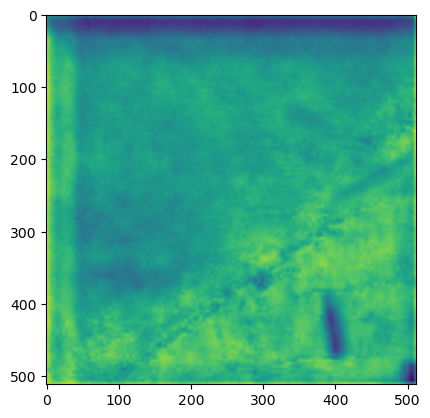

In [158]:
plt.imshow(seg_numpy[:, :, 1])

In [166]:
targets.shape

torch.Size([3, 512, 512])

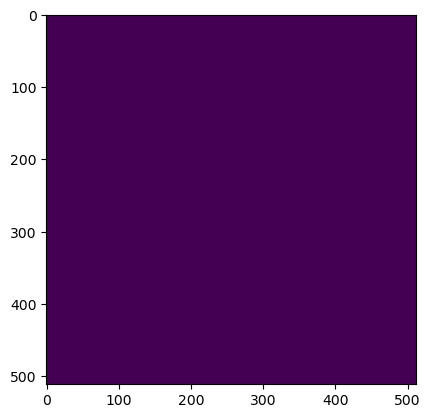

In [171]:
target_numpy = targets.permute(1, 2, 0).cpu().detach().numpy()
plt.imshow(target_numpy[:, :, 0])


In [ ]:
show = targets[0, :, :, :]

show = show.cpu().detach().numpy()

plt.imshow(show[:, :, 1])

In [190]:
# load normal mask

mask= io.imread(os.path.join(mask_dir, 
                      '627_mask.png'))

In [193]:
np.unique(mask[:, :, 0])

array([  0, 255], dtype=uint8)

In [194]:
np.unique(mask[:, :, 1])

array([  0, 255], dtype=uint8)

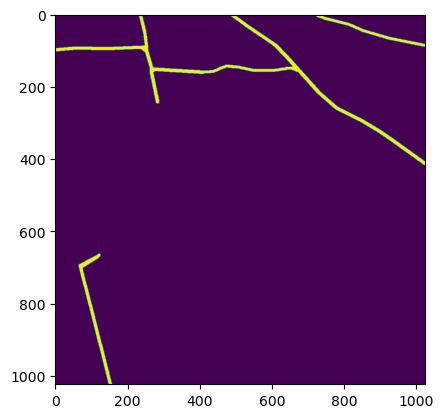

In [196]:
plt.imshow(mask[:, :, 2])

In [16]:
# read image
image_dir = r'C:\WORKS\Master_Thesis\DeepGlobeDataset\archive/train'

image = io.imread(os.path.join(image_dir, '104_sat.jpg'))


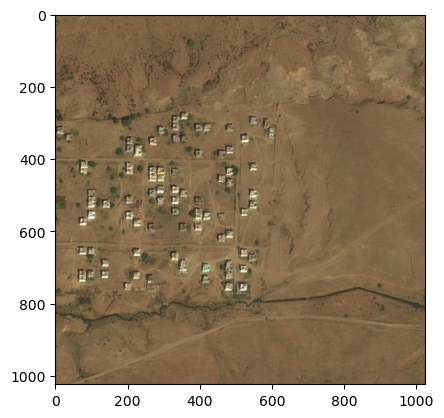

In [17]:
plt.imshow(image)

In [ ]:
image = np.array(image, np.float32)
processed_img = preprocess_input(image)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.64].


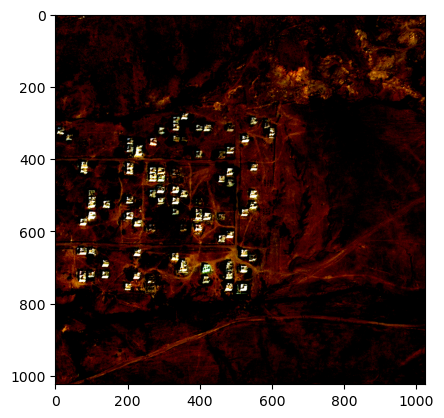

In [19]:
plt.imshow(processed_img)

In [24]:
cvtColor(image).shape

(1024, 1024, 3)